### Exercise 1 - Simulation


In this exercise, we will get to know the software tool CasADi.

We consider a simple inverted pendulum. 
The system dynamics are given via the ODE:
\begin{align}
\dot{\theta} =& \omega \\
\dot{\omega} =& \sin(\theta) + \tau,
\end{align}
where $\theta$ is the angle describing the orientation of the pendulum, $\omega$ is its angular velocity and $\tau$ is the input torque. 



In [1]:
from casadi import *

theta = SX.sym('theta', 1, 1)
omega = SX.sym('omega')

In [2]:
expr = theta**2 + omega**2

In [3]:
J = jacobian(expr, theta)

In [4]:
J_fun = Function('J_F', [theta, omega], [J])

In [5]:
J_fun(sin(theta), omega)

SX(@1=sin(theta), (@1+@1))

### 1.1 Intro to CasADi 
Check out the CasADi [documentation](https://web.casadi.org/docs/). Make sure you understand the difference between a CasADi expression and a CasADi functionCasADi. Check out the CasADi [documentation](https://web.casadi.org/docs/). Make sure you understand the difference between a CasADi expression and a CasADi function.

Define the continuous time model in terms of CasADi SX expressions.

In [6]:
from casadi import *
import numpy as np

# continuous model dynamics 

n_s = 2  # number of states
n_a = 1  # number of actions

theta = SX.sym('theta')
omega = SX.sym('omega')

tau = SX.sym('tau')

theta_dot = omega
omega_dot = sin(theta) + tau

s = vertcat(theta, omega)
s_dot = vertcat(theta_dot, omega_dot)

In [7]:
s_dot

SX([omega, (sin(theta)+tau)])

### 1.2 Differentation

Use the CasADi function `jacobian` to obtain two CasADi functions that compute the Jacobian of the continuous time dynamics with respect to states and actions respectively.

Use these functions to evaluate the Jacobians at the steady state $(0, 0)$.

What is the return type of the casadi function? How can you cast it to a numpy array? 

What is its sparsity pattern of the Jacobians? 

In [8]:
# jacobian functions 
J_s_expr = jacobian(s_dot, s)
J_a_expr = jacobian(s_dot, tau)

J_s = Function('jac_states', [s, tau], [J_s_expr])
J_a = Function('jac_actions', [s, tau], [J_a_expr])

# evaluate at steady state
s_steady = np.zeros((n_s, 1))
a_steady = np.zeros((n_a, 1))
                    
print('Jacobian w.r.t. s at the steady state')
print(J_s(s_steady, a_steady))

print('Jacobian w.r.t. a at the steady state')
print(J_a(s_steady, a_steady))    
# return type is DM, use .full() to get a numpy array

Jacobian w.r.t. s at the steady state

[[00, 1], 
 [1, 00]]
Jacobian w.r.t. a at the steady state
[00, 1]


In [9]:
J_a(s_steady, a_steady).full()

array([[0.],
       [1.]])

In [10]:
# sparsity 
sparsity_J_s = J_s(s_steady, a_steady).sparsity()

print('sparsity pattern of the Jacobian w.r.t. s at the steady state')
sparsity_J_s.spy()

sparsity pattern of the Jacobian w.r.t. s at the steady state
.*
*.


### 1.3 From continuos-time to discrete-time

We would like to build the discrete time dynamic system from the continuous time ODE using one RK4 step. 

In [11]:
def integrate_RK4(s_expr, a_expr, sdot_expr, dt, N_steps=1):
    '''RK4 integrator.
    
    s_expr, a_expr: casadi expression that have been used to define the dynamics sdot_expr
    sdot_expr:      casadi expr defining the rhs of the ode
    dt:             integration interval
    N_steps:        number of integration steps per integration interval, default:1
    '''

    h = dt/N_steps

    s_end = s_expr

    sdot_fun = Function('sdot', [s_expr, a_expr], [sdot_expr])

    for _ in range(N_steps):

        v_1 = sdot_fun(s_end, a_expr)
        v_2 = sdot_fun(s_end + 0.5 * h * v_1, a_expr) 
        v_3 = sdot_fun(s_end + 0.5 * h * v_2, a_expr)
        v_4 = sdot_fun(s_end + v_3 * h, a_expr)

        s_end = s_end + (1/6) * (v_1 + 2 * v_2 + 2 * v_3 + v_4) * h
    
    F_expr = s_end

    return F_expr

We can now use this RK4 integrator to obtain a discrete time system describin the dynamics of the inverted pendulum dynamics.

In [12]:
dt = 0.1    
N_steps = 5

F_discrete = Function('F_discrete', [s, tau], [integrate_RK4(s, tau, s_dot, dt, N_steps)])
# s^+ = F_discrete(s, a)
# a = tau

In [13]:
F_discrete

Function(F_discrete:(i0[2],i1)->(o0[2]) SXFunction)

### 1.4 Simulation

Complete the following template to simulate the system forward in time starting from the initial state $s_0=(\pi/2, 0)$ with constant input $a_k=0$, $ k=0, \ldots, 200$.
What do you observe?


In [14]:
N = 200

# state and (constant) action trajectories
s_traj  = np.zeros((n_s, N+1))
a_traj  = 0.001*np.ones((n_a, N))

# initial state
s0 = np.array([np.pi/2, 0.])

s_traj[:, 0]  = s0

# forward simulation
for n in range(N):
    s0 = s_traj[:, n]
    a0 = a_traj[:, n]
    s_traj[:, [n+1]] = F_discrete(s0, a0).full()

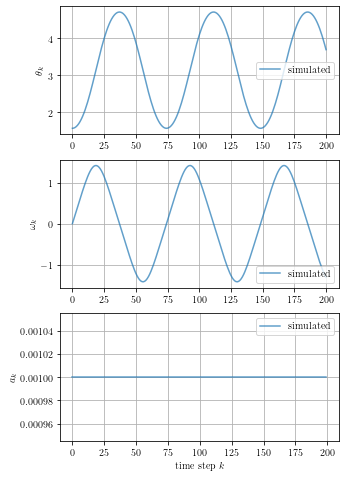

In [15]:
from plot_utils import plot_trajectories
import matplotlib.pyplot as plt

plot_trajectories(s_traj, a_traj, 'simulated')